## Start With Training

In [1]:
## Import Statements
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from PIL import Image

import torch

from transformers import AutoImageProcessor, AutoModelForImageClassification
import torch.nn as nn

import torch.optim as optim
import torch.nn as nn

from sklearn.metrics import f1_score

import os

import timm  # To use the TinyViT model

# set constants
#SEED = 19
CLASSES_NO = 37

2025-01-11 14:53:43.092595: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-11 14:53:43.216260: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-11 14:53:43.819655: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2025-01-11 14:53:43.819720

In [2]:
# Load one pretrained model
#model_name = "apple/mobilevit-xx-small"
model_name = "tiny_vit_5m_224"


In [ ]:
#from torchvision import transforms
#from torch.utils.data import Dataset, DataLoader
#import pandas as pd
#from PIL import Image

# Define a custom Dataset
class OxfordPetDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.data = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        image = Image.open(row["image_path"])
        label = int(row["class"]) - 1  # Subtract 1 to make classes zero-indexed
        
        if self.transform:
            image = self.transform(image)

        return image, label

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
trainval_data = pd.read_csv("./data/pet_dataset_info.csv").query("fold == 'trainval'")
test_data = pd.read_csv("./data/pet_dataset_info.csv").query("fold == 'test'")

train_dataset = OxfordPetDataset(trainval_data, transform=transform)
test_dataset = OxfordPetDataset(test_data, transform=transform)

# Create DataLoaders
batch_size = 16 #32 or 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
#import torch

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

In [ ]:
#from transformers import AutoImageProcessor, AutoModelForImageClassification
#import torch.nn as nn

#model_name = "apple/mobilevit-xx-small"

if model_name == "apple/mobilevit-xx-small":
    # Load the pretrained model
    processor = AutoImageProcessor.from_pretrained(model_name)
    model = AutoModelForImageClassification.from_pretrained(
        model_name,
        num_labels=CLASSES_NO,
        ignore_mismatched_sizes=True  # Ensures compatibility with new classifier
    )
    # Update the classifier to match the dataset classes
    model.classifier = nn.Linear(model.classifier.in_features, CLASSES_NO)
else:
    #import timm
    model = timm.create_model(model_name, pretrained=True,num_classes=CLASSES_NO) #num_classes=len(train_dataset.classes))

# Move the model to the device
model = model.to(device)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
#import torch.optim as optim
#import torch.nn as nn

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [ ]:
#import torch.nn as nn
#import torch.optim as optim

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
learning_rate = 1e-4  # You can experiment with this value
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-5)

# Print confirmation
print("Loss function and optimizer are defined.")

def train_model(model, train_loader, val_loader, criterion, optimizer, device, model_name, num_epochs=10, save_path="models"):
    """
    Trains and validates a model, and saves it dynamically.
    
    Parameters:
        - model: The PyTorch model to train.
        - train_loader: DataLoader for the training set.
        - val_loader: DataLoader for the validation set.
        - criterion: Loss function.
        - optimizer: Optimization algorithm.
        - device: 'cuda' or 'cpu'.
        - model_name: Name of the model (used in saving the file).
        - num_epochs: Number of epochs to train.
        - save_path: Directory where the model will be saved.
    """
    # Ensure the save path exists
    os.makedirs(save_path, exist_ok=True)

    # Move the model to the specified device
    model.to(device)

    for epoch in range(num_epochs):
        # Training Phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            optimizer.zero_grad()
            outputs = model(images)

            # Handle logits for specific model types
            logits = outputs.logits if hasattr(outputs, 'logits') else outputs
            loss = criterion(logits, labels)

            # Backward pass
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(logits, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_accuracy = correct / total

        # Validation Phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        all_labels = []
        all_predictions = []

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)

                # Handle logits for specific model types
                logits = outputs.logits if hasattr(outputs, 'logits') else outputs
                loss = criterion(logits, labels)

                val_loss += loss.item()
                _, predicted = torch.max(logits, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                # Collect predictions and labels for F1 score
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())

        val_accuracy = correct / total

        # Calculate F1 score
        f1 = f1_score(all_labels, all_predictions, average='weighted')

        # Print stats for the epoch
        print(f"Epoch {epoch + 1}/{num_epochs}, "
              f"Train Loss: {running_loss / len(train_loader):.4f}, "
              f"Train Accuracy: {train_accuracy:.4f}, "
              f"Val Loss: {val_loss / len(val_loader):.4f}, "
              f"Val Accuracy: {val_accuracy:.4f}, "
              f"F1 Score: {f1:.4f}")

In [ ]:
#Train the model in 10 intervals
torch.cuda.empty_cache()
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    model_name=model_name,  # apple/mobilevit-xx-small or "tiny_vit_5m_224"
    num_epochs=num_epochs
)


In [ ]:
#model_save_path = "models/mobilevit_xx_small_oxford_pet_WITH_NEW_DATA_SET.pth"
#torch.save(model.state_dict(), model_save_path)
#print(f"Model saved to {model_save_path}")

from datetime import datetime

# Generate the current date and time without seconds
current_time = datetime.now().strftime("%Y-%m-%d_%H-%M")

# Dynamically create the save path
model_save_path = f"models/{model_name.replace('/', '_')}_{current_time}.pth"

# Save the model
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")


## Start With Classifying without watermarks

In [28]:
#model_save_path = f"models/tiny_vit_5m_224_2025-01-06_17-38.pth"
#model_save_path = f"models/tiny_vit_5m_224_2025-01-06_17-38.pth"

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if model_name == "apple/mobilevit-xx-small":
    print("Using MobileViT")
    # Load the processor
    processor = AutoImageProcessor.from_pretrained(model_name)

    # Load the pretrained model
    model = AutoModelForImageClassification.from_pretrained(
        model_name,
        num_labels=num_classes,
        ignore_mismatched_sizes=True
    )
    # Update the classifier to match the dataset classes
    model.classifier = nn.Linear(model.classifier.in_features, num_classes)

elif model_name == "tiny_vit_5m_224":
    print("Using TinyViT")
    # Import timm for TinyViT model loading
    import timm

    # Load the pretrained TinyViT model
    model = timm.create_model(model_name, pretrained=True, num_classes=num_classes)

else:
    raise ValueError("Unsupported model type. Please use MobileViT or TinyViT.")

# Load fine-tuned weights
try:
    model.load_state_dict(torch.load(model_save_path))
    print("Model weights loaded successfully.")
except FileNotFoundError:
    raise FileNotFoundError(f"Model weights not found at {model_save_path}")

# Move model to the appropriate device
model = model.to(device)
model.eval()  # Set the model to evaluation mode


Using TinyViT
Model weights loaded successfully.


TinyVit(
  (patch_embed): PatchEmbed(
    (conv1): ConvNorm(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (act): GELU(approximate='none')
    (conv2): ConvNorm(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (stages): Sequential(
    (0): ConvLayer(
      (blocks): Sequential(
        (0): MBConv(
          (conv1): ConvNorm(
            (conv): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (act1): GELU(approximate='none')
          (conv2): ConvNorm(
            (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=256, bias=Fals

In [7]:
# Define image preprocessing transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize image to 224x224
    transforms.ToTensor(),          # Convert image to tensor
    transforms.Normalize(           # Normalize with ImageNet statistics
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [ ]:
def classify_images_from_folder(folder_path, model, transform, device):
    predictions = []

    for image_name in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image_name)

        # Skip non-image files
        if not image_name.lower().endswith((".jpg", ".jpeg", ".png")):
            continue

        # Open and preprocess the image
        image = Image.open(image_path).convert("RGB")
        input_tensor = transform(image).unsqueeze(0).to(device)

        # Perform inference
        with torch.no_grad():
            outputs = model(input_tensor).logits
            predicted_class = torch.argmax(outputs, dim=1).item()
            predictions.append({"image_name": image_name, "predicted_class": predicted_class})

    # Return predictions as a DataFrame
    return pd.DataFrame(predictions)


In [8]:
def classify_images_from_folder(folder_path, model, transform, device):
    predictions = []

    for image_name in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image_name)

        # Skip non-image files
        if not image_name.lower().endswith((".jpg", ".jpeg", ".png")):
            continue

        # Open and preprocess the image
        image = Image.open(image_path).convert("RGB")
        input_tensor = transform(image).unsqueeze(0).to(device)

        # Perform inference
        with torch.no_grad():
            outputs = model(input_tensor)  # Get raw model output
            if isinstance(outputs, torch.Tensor):  # Check if it's a PyTorch model
                predicted_class = torch.argmax(outputs, dim=1).item()
            else:  # Assume it's a Hugging Face model output
                predicted_class = torch.argmax(outputs.logits, dim=1).item()
            predictions.append({"image_name": image_name, "predicted_class": predicted_class})

    # Return predictions as a DataFrame
    return pd.DataFrame(predictions)

In [9]:
# Define paths to the folders
test_folder = "./data/resized_images/test"
#trainval_folder = "./data/resized_images/trainval"

# Classify images in test folder
test_predictions = classify_images_from_folder(test_folder, model, transform, device)

# Classify images in trainval folder
#trainval_predictions = classify_images_from_folder(trainval_folder, model, transform, device)


In [10]:
# Load ground truth data
pet_dataset_info = pd.read_csv("./data/pet_dataset_info.csv")

# Display first few rows
print(pet_dataset_info.head())


       image_name                                         image_path  class  \
0    Abyssinian_1    ./data/resized_images/trainval/Abyssinian_1.jpg    1.0   
1   Abyssinian_10   ./data/resized_images/trainval/Abyssinian_10.jpg    1.0   
2  Abyssinian_100  ./data/resized_images/trainval/Abyssinian_100.jpg    1.0   
3  Abyssinian_101  ./data/resized_images/trainval/Abyssinian_101.jpg    1.0   
4  Abyssinian_102  ./data/resized_images/trainval/Abyssinian_102.jpg    1.0   

       fold  
0  trainval  
1  trainval  
2  trainval  
3  trainval  
4  trainval  


In [11]:
print(test_predictions.head())

           image_name  predicted_class
0    Abyssinian_2.jpg                0
1   Abyssinian_20.jpg                0
2  Abyssinian_201.jpg                0
3  Abyssinian_202.jpg                0
4  Abyssinian_204.jpg                0


In [13]:
# Adjust the predicted_class by subtracting 1
test_predictions["predicted_class"] = test_predictions["predicted_class"] + 1

# Merge test predictions with ground truth
test_predictions["image_name"] = test_predictions["image_name"].map(lambda x: x.replace(".jpg", ""))
test_comparison = pd.merge(test_predictions, pet_dataset_info, on="image_name", how="inner")

# Check if predictions match ground truth
test_comparison["is_correct"] = test_comparison["predicted_class"] == test_comparison["class"]


# Merge trainval predictions with ground truth
#trainval_predictions["image_name"] = trainval_predictions["image_name"].map(lambda x: x.replace(".jpg", ""))
#trainval_comparison = pd.merge(trainval_predictions, pet_dataset_info, on="image_name", how="inner")
#trainval_comparison["is_correct"] = trainval_comparison["predicted_class"] == (trainval_comparison["class"] - 1)

# Display comparisons
print(test_comparison[["image_name", "predicted_class", "class", "is_correct"]])
#print(trainval_comparison[["image_name", "predicted_class", "class", "is_correct"]])


                image_name  predicted_class  class  is_correct
0             Abyssinian_2                1    1.0        True
1            Abyssinian_20                1    1.0        True
2           Abyssinian_201                1    1.0        True
3           Abyssinian_202                1    1.0        True
4           Abyssinian_204                1    1.0        True
...                    ...              ...    ...         ...
3664  yorkshire_terrier_95               37   37.0        True
3665  yorkshire_terrier_96               37   37.0        True
3666  yorkshire_terrier_97               37   37.0        True
3667  yorkshire_terrier_98               37   37.0        True
3668  yorkshire_terrier_99               31   37.0       False

[3669 rows x 4 columns]


In [14]:
# Calculate accuracy for test data
test_accuracy = test_comparison["is_correct"].mean()
print(f"Test Accuracy: {test_accuracy:.2%}")

# Calculate accuracy for trainval data
#trainval_accuracy = trainval_comparison["is_correct"].mean()
#print(f"Trainval Accuracy: {trainval_accuracy:.2%}")


Test Accuracy: 88.20%


In [15]:
# Save test predictions
test_comparison.to_csv("./data/test_predictions_comparison.csv", index=False)
print("Test predictions saved to ./data/test_predictions_comparison.csv")

# Save trainval predictions
#trainval_comparison.to_csv("./data/trainval_predictions_comparison.csv", index=False)
#print("Trainval predictions saved to ./data/trainval_predictions_comparison.csv")


Test predictions saved to ./data/test_predictions_comparison.csv


In [16]:
#from sklearn.metrics import f1_score

# For test data
y_pred_test = test_comparison["predicted_class"]
y_true_test = test_comparison["class"] - 1  # Convert to zero-indexed

f1_test_weighted = f1_score(y_true_test, y_pred_test, average="weighted")
f1_test_macro = f1_score(y_true_test, y_pred_test, average="macro")

print(f"Test F1 Score (Weighted): {f1_test_weighted:.4f}")
print(f"Test F1 Score (Macro): {f1_test_macro:.4f}")

# For trainval data
#y_pred_trainval = trainval_comparison["predicted_class"]
#y_true_trainval = trainval_comparison["class"] - 1  # Convert to zero-indexed

#f1_trainval_weighted = f1_score(y_true_trainval, y_pred_trainval, average="weighted")
#f1_trainval_macro = f1_score(y_true_trainval, y_pred_trainval, average="macro")

#print(f"Trainval F1 Score (Weighted): {f1_trainval_weighted:.4f}")
#print(f"Trainval F1 Score (Macro): {f1_trainval_macro:.4f}")


Test F1 Score (Weighted): 0.0098
Test F1 Score (Macro): 0.0095


## Start With Classifying with watermarks




In [18]:
def classify_images(folder_path, model, transform, device):
    predictions = []

    for image_name in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image_name)

        # Skip non-image files
        if not image_name.lower().endswith((".jpg", ".jpeg", ".png")):
            continue

        # Open and preprocess the image
        image = Image.open(image_path).convert("RGB")
        input_tensor = transform(image).unsqueeze(0).to(device)

        # Perform inference
        with torch.no_grad():
            outputs = model(input_tensor)  # Get raw model output
            if isinstance(outputs, torch.Tensor):  # Check if it's a PyTorch model
                predicted_class = torch.argmax(outputs, dim=1).item()
            else:  # Assume it's a Hugging Face model output
                predicted_class = torch.argmax(outputs.logits, dim=1).item()
            predictions.append({"image_name": image_name, "predicted_class": predicted_class})

    # Return predictions as a DataFrame
    return pd.DataFrame(predictions)


In [19]:
#Classify Test Images

# Path to test folder
test_folder = "./data/images_with_logos/test"

# Classify images in the test folder
predictions_df = classify_images(test_folder, model, transform, device)

# Display predictions
print(predictions_df.head())



        image_name  predicted_class
0  keeshond_32.jpg               24
1  keeshond_36.jpg               18
2  keeshond_37.jpg               18
3  keeshond_33.jpg               30
4  keeshond_34.jpg               18


In [20]:

# Load ground truth data
pet_dataset_info = pd.read_csv("./data/pet_dataset_info.csv")

# Display the first few rows to verify
print(pet_dataset_info.head())



       image_name                                         image_path  class  \
0    Abyssinian_1    ./data/resized_images/trainval/Abyssinian_1.jpg    1.0   
1   Abyssinian_10   ./data/resized_images/trainval/Abyssinian_10.jpg    1.0   
2  Abyssinian_100  ./data/resized_images/trainval/Abyssinian_100.jpg    1.0   
3  Abyssinian_101  ./data/resized_images/trainval/Abyssinian_101.jpg    1.0   
4  Abyssinian_102  ./data/resized_images/trainval/Abyssinian_102.jpg    1.0   

       fold  
0  trainval  
1  trainval  
2  trainval  
3  trainval  
4  trainval  


In [21]:
#Compare Predictions with Ground Truth
# Merge predictions with ground truth
# Remove .jpg extension from image_name in predictions_df
predictions_df["image_name"] = predictions_df["image_name"].map(lambda x: x.replace(".jpg", ""))

comparison_df = pd.merge(predictions_df, pet_dataset_info, on="image_name", how="inner")


comparison_df["predicted_class"] = comparison_df["predicted_class"] + 1
# Add a comparison column
comparison_df["is_correct"] = comparison_df["predicted_class"] == (comparison_df["class"])  # Subtract 1 for 0-indexed classes

# Display comparison
print(comparison_df[["image_name", "predicted_class", "class", "is_correct"]])



       image_name  predicted_class  class  is_correct
0     keeshond_32               25   19.0       False
1     keeshond_36               19   19.0        True
2     keeshond_37               19   19.0        True
3     keeshond_33               31   19.0       False
4     keeshond_34               19   19.0        True
...           ...              ...    ...         ...
3664  keeshond_28               19   19.0        True
3665  keeshond_29               19   19.0        True
3666  keeshond_27               19   19.0        True
3667  keeshond_30               19   19.0        True
3668  keeshond_31               18   19.0       False

[3669 rows x 4 columns]


In [22]:
# Calculate accuracy
accuracy = comparison_df["is_correct"].mean()
print(f"Accuracy: {accuracy:.2%}")


Accuracy: 81.49%


In [23]:
#import pandas as pd

# Load the pet_dataset_info.csv
pet_dataset_info = pd.read_csv("./data/pet_dataset_info.csv")

# Display the first few rows to verify
print(pet_dataset_info.head())

       image_name                                         image_path  class  \
0    Abyssinian_1    ./data/resized_images/trainval/Abyssinian_1.jpg    1.0   
1   Abyssinian_10   ./data/resized_images/trainval/Abyssinian_10.jpg    1.0   
2  Abyssinian_100  ./data/resized_images/trainval/Abyssinian_100.jpg    1.0   
3  Abyssinian_101  ./data/resized_images/trainval/Abyssinian_101.jpg    1.0   
4  Abyssinian_102  ./data/resized_images/trainval/Abyssinian_102.jpg    1.0   

       fold  
0  trainval  
1  trainval  
2  trainval  
3  trainval  
4  trainval  


In [24]:
# Save the comparison DataFrame to a CSV file
comparison_df.to_csv("./data/predictions_comparison.csv", index=False)

print("Predictions comparison saved to ./data/predictions_comparison.csv")



Predictions comparison saved to ./data/predictions_comparison.csv


In [25]:
#from sklearn.metrics import f1_score

# For test data
y_pred_test = comparison_df["predicted_class"]
y_true_test = comparison_df["class"] - 1  # Convert to zero-indexed

f1_test_weighted = f1_score(y_true_test, y_pred_test, average="weighted")
f1_test_macro = f1_score(y_true_test, y_pred_test, average="macro")

print(f"Test F1 Score (Weighted): {f1_test_weighted:.4f}")
print(f"Test F1 Score (Macro): {f1_test_macro:.4f}")




Test F1 Score (Weighted): 0.0144
Test F1 Score (Macro): 0.0139


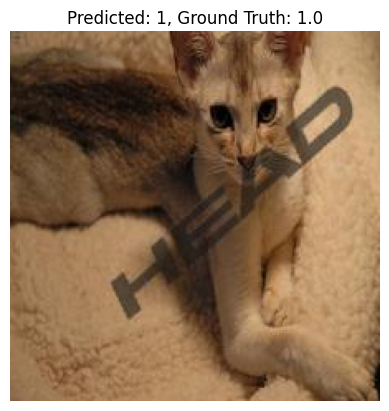

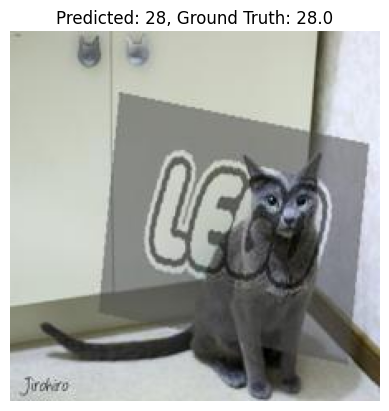

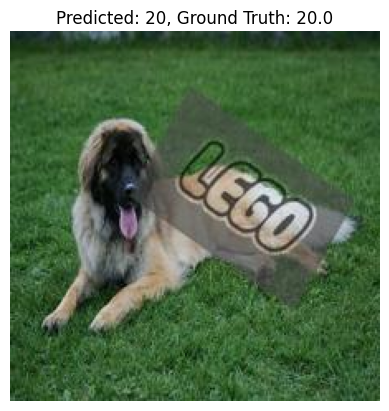

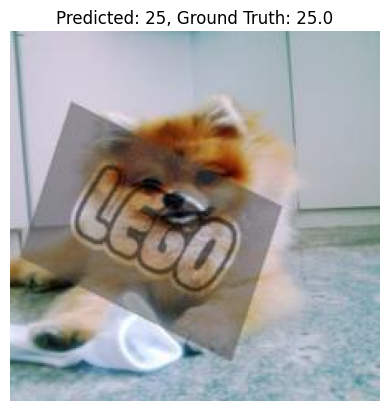

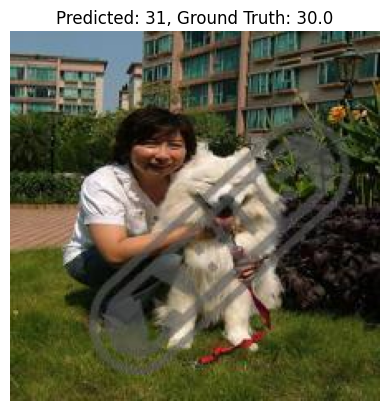

In [27]:
import matplotlib.pyplot as plt
from PIL import Image

# Display 5 random classified images with labels
sampled_df = comparison_df.sample(5)
for _, row in sampled_df.iterrows():
    image_path = os.path.join(test_folder, f"{row['image_name']}.jpg")  # Adjust folder as needed
    image = Image.open(image_path)
    
    # Display the image inline
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Predicted: {row['predicted_class']}, Ground Truth: {row['class']}")
    plt.show()


